# Modeling Vaccination


In [ ]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [16]:
import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [3]:
def make_system(beta, gamma):
    init = modsim.State(s=89, i=1, r=0)
    init /= init.sum()

    return modsim.System(
        init=init, t_end=7*14,
        beta=beta, gamma=gamma,
    )

In [4]:
def update_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return modsim.State(s=s, i=i, r=r)

In [5]:
def run_simulation(system, update_func):
    frame = modsim.TimeFrame(columns=system.init.index)
    frame.loc[0] = system.init
    
    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system)
    
    return frame

In [6]:
def plot_results(S, I, R):
    S.plot(linestyle='--', label='Susceptible')
    I.plot(linestyle='-', label='Infected')
    R.plot(linestyle=':', label='Resistant')
    modsim.decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

### Immunization

In [2]:
def add_immunization(system, fraction):
    system.init.s -= fraction
    system.init.r += fraction

In [7]:
tc = 3             # time between contacts in days 
tr = 4             # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)

In [8]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)

In [9]:
results2 = run_simulation(system2, update_func)

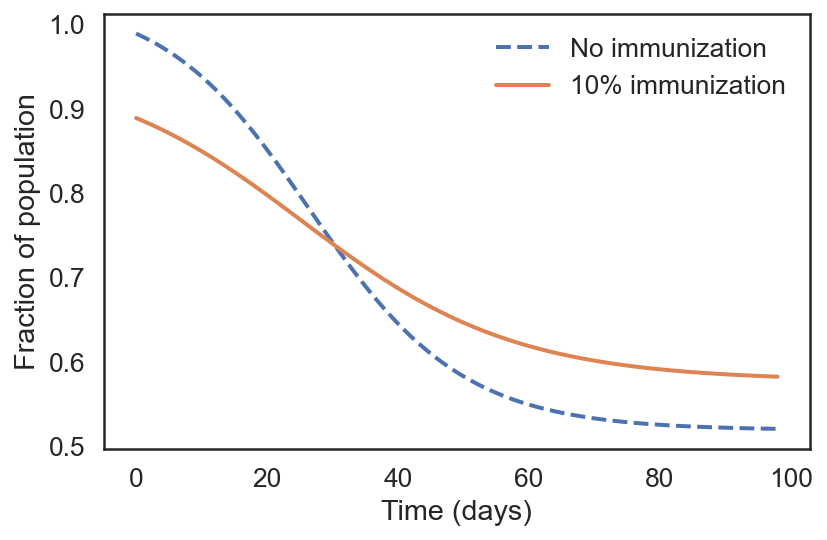

In [11]:
results.s.plot(linestyle='--', label='No immunization')
results2.s.plot(label='10% immunization')

modsim.decorate(xlabel='Time (days)',
         ylabel='Fraction of population')

### Metrics

In [12]:
def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system.t_end]
    return s_0 - s_end

In [13]:
calc_total_infected(results, system)

0.468320811028781

In [14]:
calc_total_infected(results2, system2)

0.30650802853979753

### Sweeping Immunization

In [15]:
def sweep_immunity(fraction_array):
    sweep = modsim.SweepSeries()

    for fraction in fraction_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results, system)

    return sweep

In [17]:
fraction_array = numpy.linspace(0, 1, 21)
infected_sweep = sweep_immunity(fraction_array)

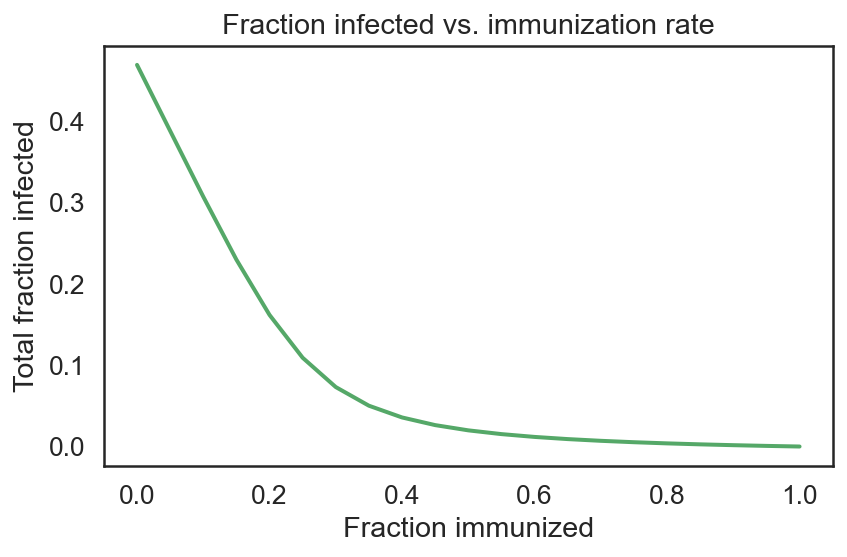

In [18]:
infected_sweep.plot(color='C2')

modsim.decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate')

### Exercise 1
Suppose we have the option to quarantine infected students. 
For example, a student who feels ill might be moved to an infirmary or a private dorm room until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

In [19]:
# Solution

"""There is no unique best answer to this question,
but one simple option is to model quarantine as an
effective reduction in gamma, on the assumption that
quarantine reduces the number of infectious contacts
per infected student.

Another option would be to add a fourth compartment
to the model to track the fraction of the population
in quarantine at each point in time.  This approach
is more complex and might not be substantially better.

The following function could be used, like 
`add_immunization`, to adjust the
parameters in order to model various interventions.

In this example, `high` is the highest duration of
the infection period, with no quarantine.  `low` is
the lowest duration, on the assumption that it takes
some time to identify infectious students.

`fraction` is the fraction of infected students who 
are quarantined as soon as they are identified.
"""

def add_quarantine(system, fraction):
    """Model the effect of quarantine by adjusting gamma.
    
    system: System object
    fraction: fraction of students quarantined
    """
    # `low` represents the number of days a student 
    # is infectious if quarantined.
    # `high` is the number of days they are infectious
    # if not quarantined
    low = 1
    high = 4
    tr = high - fraction * (high-low)
    system.gamma = 1 / tr

In [20]:
# Solution

def sweep_quarantine(fraction_array):
    sweep = modsim.SweepSeries()

    for fraction in fraction_array:
        system = make_system(beta, gamma)
        add_quarantine(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results, system)

    return sweep

In [21]:
# Solution

fraction_array = numpy.linspace(0, 1, 21)
infected_sweep2 = sweep_quarantine(fraction_array)

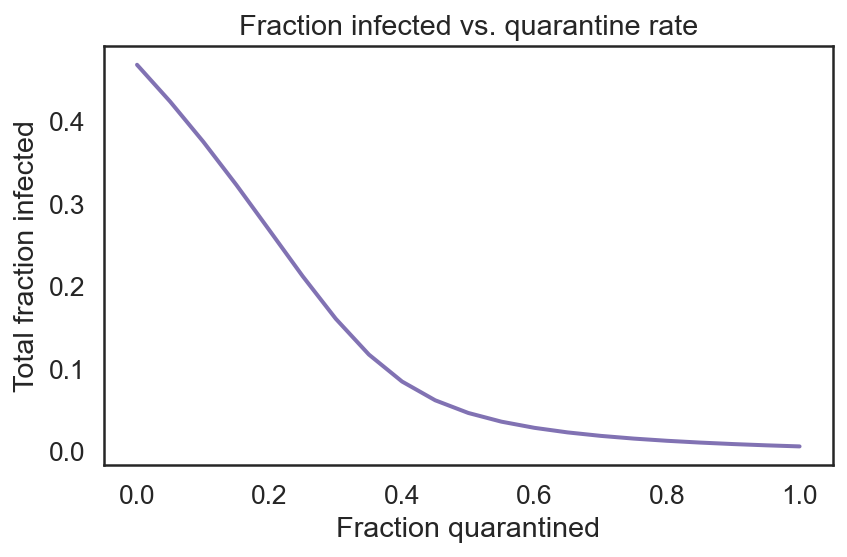

In [22]:
# Solution

infected_sweep2.plot(color='C4')

modsim.decorate(xlabel='Fraction quarantined',
         ylabel='Total fraction infected',
         title='Fraction infected vs. quarantine rate')